# Описание задачи

На дворе 29.07.2022. Есть запрос от продакт-менеджера встроить в существующий дашборд новый виджет: число привязок почт пользователей по дням за последние 45 дней.

# Решение

Импортируем нужные библиотеки

In [2]:
import pandas as pd
from sqlalchemy import create_engine

Загружаем таблицы и смотрим что получилось

In [3]:
df_profile = pd.read_csv('C:/Python/PERSONS_AUTH.csv', delimiter=',')
df_profile.head()

,prs_id,prs_creation_date,bound_email
0,7608927637027400000,2019-10-28 12:40:13.000000,2236330614944998422@qiwi
1,3981260155811510000,2017-10-14 23:03:42.000000,NaN
2,2061196687922740000,2019-11-05 02:33:16.000000,NaN
3,6044625676091300000,2015-03-13 21:34:38.000000,NaN
4,4328802394636760000,2022-01-29 23:46:14.000000,NaN


In [4]:
df_hist = pd.read_csv('C:/Python/PERSONS_AUTH_HISTORY.csv', delimiter=';')
df_hist.head()

,pah_prs_id,pah_prs_creation_date,pah_bound_email,pah_modify_date
0,4020172551587850000,2016-01-16 23:33:23.000000,NaN,2017-10-05 22:46:47.000000
1,8820235108258620000,2018-01-07 22:04:08.000000,NaN,2018-01-11 14:44:05.000000
2,3111584182692220000,2017-09-22 05:45:35.000000,NaN,2017-09-22 05:45:42.000000
3,2199921048971120000,2017-04-08 17:21:35.000000,5239951468638775617@qiwi,2017-09-19 21:07:39.000000
4,3880999903532200000,2017-10-03 11:21:13.000000,NaN,2017-10-03 11:21:23.000000


Загружаем датафреймы в нашу базу данных:

In [5]:
engine = create_engine('sqlite://', echo=False)
df_profile.to_sql ('users', con = engine, index = True)
df_hist.to_sql ('history', con = engine, index = True) 

21207

Мы хотим узнать как много пользователей добавило свой имэйл в отчетные дни. Для этого будем проверять был ли имэйл пустым до изменения и есть ли после изменения имэйл в базе.

In [12]:
result = engine.execute("""
WITH short_tab AS
    ( SELECT pah_prs_id as user_id
    , SUBSTRING (pah_modify_date,1,10) as event_date
    , pah_modify_date as event_time
    , pah_bound_email as event_email
    , LAST_VALUE(pah_modify_date) OVER (PARTITION BY pah_prs_id ORDER BY pah_modify_date) as last_change_time
    , LEAD(pah_bound_email) OVER (PARTITION BY pah_prs_id ORDER BY pah_modify_date) as next_email
    , u.bound_email as final_email
    FROM history h
    LEFT JOIN users u ON u.prs_id=h.pah_prs_id
    WHERE pah_modify_date >='2022-06-15')
    
    SELECT event_date
    , COUNT(DISTINCT user_id) as qty
    FROM short_tab
    WHERE (event_email IS NULL AND next_email IS NOT NULL)
       OR (event_email IS NULL AND final_email IS NOT NULL AND event_time = last_change_time)
    GROUP BY event_date
    ORDER BY event_date
""").fetchall()
df = pd.DataFrame(result)

Выведем график по полученным значениям

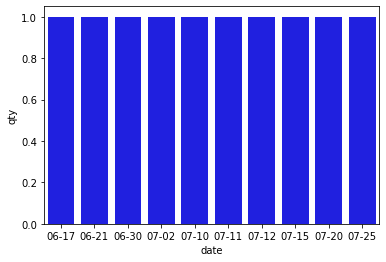

In [13]:
df['date'] = df['event_date'].str.replace('2022-','')
import seaborn as sns
ax = sns.barplot(x = 'date', y = 'qty', data = df, color = 'blue')